In [1]:
import pandas as pd
import numpy as np

In [2]:
df_sample = pd.read_csv(r"C:\Users\samar\car_price\old-_car_price_regression\data\sample_submission.csv")

In [3]:
df_sample.head()

,id,price
0,188533,43878.016
1,188534,43878.016
2,188535,43878.016
3,188536,43878.016
4,188537,43878.016


In [4]:
df_train=pd.read_csv(r"C:\Users\samar\car_price\old-_car_price_regression\data\train.csv")
df_train.sample(2)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
142762,142762,Chevrolet,Corvette Base,2008,122961,Gasoline,400.0HP 6.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,13900
52970,52970,BMW,X5 xDrive35i,2014,89563,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Blue,White,None reported,Yes,35645


In [5]:
df_train[["brand","fuel_type"]].nunique()

brand        57
fuel_type     7
dtype: int64

In [6]:
df_train[["fuel_type"]].value_counts()



fuel_type     
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [7]:
df_train.columns.tolist()


['id',
 'brand',
 'model',
 'model_year',
 'milage',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'price']

In [8]:
df_train[["clean_title"]].nunique()



clean_title    1
dtype: int64

In [9]:
import os
data_path = r"C:\Users\samar\car_price\old-_car_price_regression\data\train.csv"

if not os.path.exists(data_path):
    print(f"Error: File not found at {data_path}")
    exit(1)

df = pd.read_csv(data_path)

print("--- Data Info ---")
print(df.info())
print("\n--- Numerical Description ---")
print(df.describe())
print("\n--- Categorical Description ---")
print(df.describe(include=['O']))

print("\n--- Unique Values Count ---")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

print("\n--- Sample Values (First 5) ---")
print(df.head())

print("\n--- Value Counts for Low Cardinality Columns (<20 unique) ---")
for col in df.columns:
    if df[col].nunique() < 20:
        print(f"\nCol: {col}")
        print(df[col].value_counts())

print("\n--- 'engine' Sample Values (Top 20) ---")
print(df['engine'].value_counts().head(20))

print("\n--- 'transmission' Sample Values (Top 20) ---")
print(df['transmission'].value_counts().head(20))


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB
None

--- Numerical Description ---
                  id     model_year         milage         price
count  188533.000000  188533.000000  188533.000000  1.885330e+05
mean    9

In [10]:
df_test=pd.read_csv(r"C:\Users\samar\car_price\old-_car_price_regression\data\test.csv")

In [11]:
# drop id and clean_title
# drop ext_col and int_col

df_train.drop(columns=['id', 'clean_title', 'ext_col', 'int_col'], inplace=True)
df_test.drop(columns=['id', 'clean_title', 'ext_col', 'int_col'], inplace=True)



In [12]:
# df['accident_status'] = (df['accident'] != 0).astype(int)
df_train['accident_binary'] = df_train['accident'].str.contains('At least 1 accident', na=False).astype(int)


In [13]:
df_train.drop('accident', axis=1, inplace=True)

In [14]:
df_train.head(1
)

,brand,model,model_year,milage,fuel_type,engine,transmission,price,accident_binary
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,4200,0


In [15]:
def smoothed_target_encoding(df, cat_col, target_col, m=5):
    global_mean = df[target_col].mean()

    stats = df.groupby(cat_col)[target_col].agg(['mean', 'count'])

    stats['smoothed'] = (
        (stats['count'] * stats['mean'] + m * global_mean) /
        (stats['count'] + m)
    )

    return df[cat_col].map(stats['smoothed'])


In [16]:
from sklearn.preprocessing import StandardScaler

# 1. brand: Target Encoding (mean price per brand)
df_train['brand_enc'] = smoothed_target_encoding(
    df_train,
    cat_col='brand',
    target_col='price',
    m=3
)

# 2. model_year: Create car_age feature
df_train['car_age'] = 2025 - df_train['model_year']

# 3. milage: Scale using StandardScaler
scaler = StandardScaler()
df_train['milage_scaled'] = scaler.fit_transform(df_train[['milage']])


In [17]:
df_train.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,price,accident_binary,brand_enc,car_age,milage_scaled
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,4200,0,17237.131254,18,2.957842
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,4999,1,30728.875535,23,1.557184
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,13900,0,41837.129945,23,1.426276
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,45000,0,53526.455811,8,-0.927854
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,97500,0,51243.247043,4,-1.171076


In [18]:
import pandas as pd
import re

# 5. Engine Feature Extraction
df_train['horsepower'] = df_train['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
df_train['engine_displacement'] = df_train['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
df_train['cylinders'] = df_train['engine'].str.extract(r'(\d+)\s*Cylinder').astype(float)
df_train.drop(columns=['engine'], inplace=True)

# 6. Transmission Feature Extraction & Simplification
df_train['transmission_speeds'] = df_train['transmission'].str.extract(r'(\d+)-Speed').astype(float)

def categorize_transmission(trans):
    trans = str(trans).lower()
    if 'cvt' in trans: return 'CVT'
    if 'dual shift' in trans or 'dct' in trans: return 'Dual Shift'
    if 'm/t' in trans or 'manual' in trans: return 'Manual'
    if 'a/t' in trans or 'automatic' in trans: return 'Automatic'
    return 'Other'

df_train['transmission_type'] = df_train['transmission'].apply(categorize_transmission)
df_train.drop(columns=['transmission'], inplace=True)

# 7. Fuel Type Cleaning & Encoding
df_train['fuel_type'] = df_train['fuel_type'].replace(['–', 'not supported'], 'Unknown')
df_train = pd.get_dummies(df_train, columns=['fuel_type'], prefix='fuel')


In [19]:
df_train.head(1)

,brand,model,model_year,milage,price,accident_binary,brand_enc,car_age,milage_scaled,horsepower,engine_displacement,cylinders,transmission_speeds,transmission_type,fuel_Diesel,fuel_E85 Flex Fuel,fuel_Gasoline,fuel_Hybrid,fuel_Plug-In Hybrid,fuel_Unknown
0,MINI,Cooper S Base,2007,213000,4200,0,17237.131254,18,2.957842,172.0,1.6,4.0,NaN,Automatic,False,False,True,False,False,False


In [20]:
df_train.drop(['brand'],axis=1,inplace=True)

In [21]:

df_train['brand_scaled'] = scaler.fit_transform(df_train[['brand_enc']])

In [25]:
df_train.head()

,model,model_year,milage,price,accident_binary,car_age,milage_scaled,horsepower,engine_displacement,cylinders,transmission_speeds,transmission_type,fuel_Diesel,fuel_E85 Flex Fuel,fuel_Gasoline,fuel_Hybrid,fuel_Plug-In Hybrid,fuel_Unknown,brand_scaled
0,Cooper S Base,2007,213000,4200,0,18,2.957842,172.0,1.6,4.0,NaN,Automatic,False,False,True,False,False,False,-1.588106
1,LS V8,2002,143250,4999,1,23,1.557184,252.0,3.9,8.0,NaN,Automatic,False,False,True,False,False,False,-0.783717
2,Silverado 2500 LT,2002,136731,13900,0,23,1.426276,320.0,5.3,8.0,NaN,Automatic,False,True,False,False,False,False,-0.121434
3,G90 5.0 Ultimate,2017,19500,45000,0,8,-0.927854,420.0,5.0,8.0,NaN,Dual Shift,False,False,True,False,False,False,0.575493
4,Metris Base,2021,7388,97500,0,4,-1.171076,208.0,2.0,4.0,7.0,Automatic,False,False,True,False,False,False,0.439366


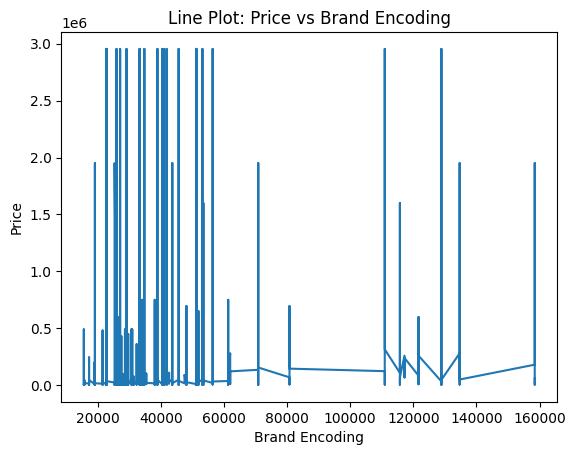

In [ ]:
import matplotlib.pyplot as plt

# Sort values so the line looks meaningful
df_sorted = df.sort_values(by='brand_enc')

plt.figure()
plt.plot(df_sorted['brand_enc'], df_sorted['price'])
plt.xlabel('Brand Encoding')
plt.ylabel('Price')
plt.title('Line Plot: Price vs Brand Encoding')
plt.show()


In [24]:
df_train.drop('brand_enc', axis=1, inplace=True)

In [26]:
df_train.drop('model', axis=1, inplace=True)

In [28]:
df_train.drop('milage', axis=1, inplace=True)

In [32]:
df_train.head()

,model_year,price,accident_binary,car_age,milage_scaled,horsepower,engine_displacement,cylinders,transmission_speeds,fuel_Diesel,...,fuel_Gasoline,fuel_Hybrid,fuel_Plug-In Hybrid,fuel_Unknown,brand_scaled,transmission_type_Automatic,transmission_type_CVT,transmission_type_Dual Shift,transmission_type_Manual,transmission_type_Other
0,2007,4200,0,18,2.957842,172.0,1.6,4.0,NaN,False,...,True,False,False,False,-1.588106,1,0,0,0,0
1,2002,4999,1,23,1.557184,252.0,3.9,8.0,NaN,False,...,True,False,False,False,-0.783717,1,0,0,0,0
2,2002,13900,0,23,1.426276,320.0,5.3,8.0,NaN,False,...,False,False,False,False,-0.121434,1,0,0,0,0
3,2017,45000,0,8,-0.927854,420.0,5.0,8.0,NaN,False,...,True,False,False,False,0.575493,0,0,1,0,0
4,2021,97500,0,4,-1.171076,208.0,2.0,4.0,7.0,False,...,True,False,False,False,0.439366,1,0,0,0,0


In [31]:
df_train = pd.get_dummies(df_train, columns=['transmission_type'], dtype=int)


In [33]:
df_train['transmission_speeds'].value_counts()

transmission_speeds
6.0     33221
8.0     29653
7.0     13027
10.0    11248
9.0      6224
5.0      5785
4.0      2594
1.0      2234
2.0        93
Name: count, dtype: int64

In [35]:
df_train['transmission_speeds'].isna().sum()

np.int64(84454)

In [37]:
df_train['transmission_speeds'] = df_train['transmission_speeds'].fillna(0)


In [38]:
df_train.head()

,model_year,price,accident_binary,car_age,milage_scaled,horsepower,engine_displacement,cylinders,transmission_speeds,fuel_Diesel,...,fuel_Gasoline,fuel_Hybrid,fuel_Plug-In Hybrid,fuel_Unknown,brand_scaled,transmission_type_Automatic,transmission_type_CVT,transmission_type_Dual Shift,transmission_type_Manual,transmission_type_Other
0,2007,4200,0,18,2.957842,172.0,1.6,4.0,0.0,False,...,True,False,False,False,-1.588106,1,0,0,0,0
1,2002,4999,1,23,1.557184,252.0,3.9,8.0,0.0,False,...,True,False,False,False,-0.783717,1,0,0,0,0
2,2002,13900,0,23,1.426276,320.0,5.3,8.0,0.0,False,...,False,False,False,False,-0.121434,1,0,0,0,0
3,2017,45000,0,8,-0.927854,420.0,5.0,8.0,0.0,False,...,True,False,False,False,0.575493,0,0,1,0,0
4,2021,97500,0,4,-1.171076,208.0,2.0,4.0,7.0,False,...,True,False,False,False,0.439366,1,0,0,0,0


In [40]:
df_train.shape

(188533, 21)

In [42]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings

In [56]:
target = 'price'
X = df_train.drop(columns=[target])
y = df_train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Model Training (XGBoost)
print("Training XGBoost Model...")
model = XGBRegressor(
    n_estimators=1300,
    learning_rate=0.122,
    max_depth=5,
    subsample=1,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

# 7. Evaluation
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("\n--- Model Performance ---")
print(f"MAE:  ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"R2:   {r2:.4f}")

# Feature Importance
print("\n--- Top 10 Feature Importances ---")
importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(10))
mape = np.mean(np.abs((y_test - predictions) / y_test))
accuracy = (1 - mape) * 100
print(f"Model Accuracy: {accuracy:.2f}%")


Training XGBoost Model...
[0]	validation_0-rmse:73574.32809
[100]	validation_0-rmse:68173.66364
[200]	validation_0-rmse:68425.25904
[300]	validation_0-rmse:68848.18239
[400]	validation_0-rmse:69210.92431
[500]	validation_0-rmse:69505.09076
[600]	validation_0-rmse:69830.28114
[700]	validation_0-rmse:70073.92086
[800]	validation_0-rmse:70338.76255
[900]	validation_0-rmse:70687.93285
[1000]	validation_0-rmse:71032.58406
[1100]	validation_0-rmse:71391.50278
[1200]	validation_0-rmse:71718.96165
[1299]	validation_0-rmse:71933.36200

--- Model Performance ---
MAE:  $20,819.06
RMSE: $71,933.37
R2:   0.0695

--- Top 10 Feature Importances ---
model_year                      0.093077
milage_scaled                   0.081345
horsepower                      0.071495
transmission_type_Automatic     0.071472
transmission_type_Dual Shift    0.069460
accident_binary                 0.067841
brand_scaled                    0.064684
engine_displacement             0.061508
car_age                       

In [57]:
df_test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,accident
0,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,None reported
1,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,None reported
2,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,None reported
3,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,None reported
4,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,None reported


In [65]:
df_ttrain= pd.read_csv(r"C:\Users\samar\car_price\old-_car_price_regression\data\train.csv")
df_ttrain.head(4)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000


In [66]:
def preprocess_data(df, is_train=True):
    df = df.copy()
    
    # Feature Extraction
    df['hp'] = df['engine'].apply(lambda x: float(re.search(r'(\d+\.?\d*)HP', str(x)).group(1)) if re.search(r'(\d+\.?\d*)HP', str(x)) else None)
    df['liters'] = df['engine'].apply(lambda x: float(re.search(r'(\d+\.?\d*)L', str(x)).group(1)) if re.search(r'(\d+\.?\d*)L', str(x)) else None)
    df['cylinders'] = df['engine'].apply(lambda x: int(re.search(r'(\d+)\s+Cylinder', str(x)).group(1)) if re.search(r'(\d+)\s+Cylinder', str(x)) else None)
    df['trans_speed'] = df['transmission'].apply(lambda x: int(re.search(r'(\d+)-Speed', str(x)).group(1)) if re.search(r'(\d+)-Speed', str(x)) else 0)

    # Fill Missing (using hardcoded values to avoid data leakage between train/test if simpler)
    # Ideally, compute medians from Train and apply to Test. Using rough operational defaults here:
    df['hp'] = df['hp'].fillna(df['hp'].median())
    df['liters'] = df['liters'].fillna(df['liters'].median())
    df['cylinders'] = df['cylinders'].fillna(6) # Median approx
    df['trans_speed'] = df['trans_speed'].fillna(0) # 0 for unknown
    
    # Accident
    df['accident_clean'] = df['accident'].apply(lambda x: 1 if x == 'At least 1 accident or damage reported' else 0)

    # Drop unused
    drop_cols = ['id', 'clean_title', 'model', 'engine', 'transmission', 'ext_col', 'int_col', 'accident']
    # Only drop if they exist
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    
    # Target encoding or Drop price if in test (it won't be, but good practice)
    if 'price' in df.columns and not is_train:
        df = df.drop(columns=['price'])
        
    return df

In [67]:
df_test = pd.read_csv(r"C:\Users\samar\car_price\old-_car_price_regression\data\test.csv")

# Apply cleaning
train_clean = preprocess_data(df_ttrain, is_train=True)
test_clean = preprocess_data(df_test, is_train=False)

# One-Hot Encoding
train_encoded = pd.get_dummies(train_clean, columns=['brand', 'fuel_type'], drop_first=True)
test_encoded = pd.get_dummies(test_clean, columns=['brand', 'fuel_type'], drop_first=True)

# ==========================================
# 3. Align Columns (CRITICAL STEP)
# ==========================================
# Get columns from trained X (excluding target)
target = 'price'
train_cols = train_encoded.drop(columns=[target]).columns

# Reindex test to match train columns, filling missing with 0
X_real_test = test_encoded.reindex(columns=train_cols, fill_value=0)

# ==========================================
# 4. Predict
# ==========================================
final_predictions = model.predict(X_real_test)

# Verify
print(f"Predictions shape: {final_predictions.shape}")
print(final_predictions[:5])

# Save if needed
submission = pd.DataFrame({'id': df_test['id'], 'price': final_predictions})
# submission.to_csv('submission.csv', index=False)

ValueError: feature_names mismatch: ['model_year', 'accident_binary', 'car_age', 'milage_scaled', 'horsepower', 'engine_displacement', 'cylinders', 'transmission_speeds', 'fuel_Diesel', 'fuel_E85 Flex Fuel', 'fuel_Gasoline', 'fuel_Hybrid', 'fuel_Plug-In Hybrid', 'fuel_Unknown', 'brand_scaled', 'transmission_type_Automatic', 'transmission_type_CVT', 'transmission_type_Dual Shift', 'transmission_type_Manual', 'transmission_type_Other'] ['model_year', 'milage', 'hp', 'liters', 'cylinders', 'trans_speed', 'accident_clean', 'brand_Alfa', 'brand_Aston', 'brand_Audi', 'brand_BMW', 'brand_Bentley', 'brand_Bugatti', 'brand_Buick', 'brand_Cadillac', 'brand_Chevrolet', 'brand_Chrysler', 'brand_Dodge', 'brand_FIAT', 'brand_Ferrari', 'brand_Ford', 'brand_GMC', 'brand_Genesis', 'brand_Honda', 'brand_Hummer', 'brand_Hyundai', 'brand_INFINITI', 'brand_Jaguar', 'brand_Jeep', 'brand_Karma', 'brand_Kia', 'brand_Lamborghini', 'brand_Land', 'brand_Lexus', 'brand_Lincoln', 'brand_Lotus', 'brand_Lucid', 'brand_MINI', 'brand_Maserati', 'brand_Maybach', 'brand_Mazda', 'brand_McLaren', 'brand_Mercedes-Benz', 'brand_Mercury', 'brand_Mitsubishi', 'brand_Nissan', 'brand_Plymouth', 'brand_Polestar', 'brand_Pontiac', 'brand_Porsche', 'brand_RAM', 'brand_Rivian', 'brand_Rolls-Royce', 'brand_Saab', 'brand_Saturn', 'brand_Scion', 'brand_Subaru', 'brand_Suzuki', 'brand_Tesla', 'brand_Toyota', 'brand_Volkswagen', 'brand_Volvo', 'brand_smart', 'fuel_type_E85 Flex Fuel', 'fuel_type_Gasoline', 'fuel_type_Hybrid', 'fuel_type_Plug-In Hybrid', 'fuel_type_not supported', 'fuel_type_–']
expected fuel_Unknown, fuel_Diesel, transmission_type_Manual, fuel_Gasoline, milage_scaled, transmission_type_Other, transmission_type_CVT, brand_scaled, transmission_speeds, horsepower, fuel_Plug-In Hybrid, fuel_E85 Flex Fuel, car_age, engine_displacement, accident_binary, transmission_type_Automatic, transmission_type_Dual Shift, fuel_Hybrid in input data
training data did not have the following fields: brand_Jaguar, brand_Genesis, fuel_type_Hybrid, brand_Plymouth, brand_Kia, brand_FIAT, brand_Ferrari, brand_Maserati, brand_Cadillac, brand_Suzuki, brand_Lexus, brand_Jeep, brand_Lucid, brand_Honda, brand_Porsche, fuel_type_Plug-In Hybrid, brand_Saab, brand_Bugatti, fuel_type_–, brand_Nissan, trans_speed, brand_Buick, brand_Maybach, brand_Mitsubishi, liters, brand_GMC, brand_Alfa, fuel_type_Gasoline, brand_Toyota, brand_RAM, brand_Rolls-Royce, brand_Karma, brand_Lincoln, brand_Mercury, brand_Polestar, brand_Pontiac, brand_Hummer, accident_clean, milage, brand_MINI, brand_Ford, hp, brand_BMW, brand_Bentley, brand_Land, brand_Rivian, brand_smart, brand_Subaru, brand_Hyundai, brand_McLaren, brand_Volkswagen, brand_Chevrolet, brand_Chrysler, brand_Lamborghini, brand_Volvo, brand_Lotus, brand_Audi, brand_Mazda, brand_Mercedes-Benz, brand_Tesla, brand_Scion, fuel_type_not supported, fuel_type_E85 Flex Fuel, brand_INFINITI, brand_Saturn, brand_Aston, brand_Dodge

In [68]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 1. Load Data
df_train_raw = pd.read_csv(r"C:\Users\samar\car_price\old-_car_price_regression\data\train.csv")
df_test_raw = pd.read_csv(r"C:\Users\samar\car_price\old-_car_price_regression\data\test.csv")

# 2. Define Preprocessing
def preprocess_data(df):
    df = df.copy()
    # Extract
    df['hp'] = df['engine'].apply(lambda x: float(re.search(r'(\d+\.?\d*)HP', str(x)).group(1)) if re.search(r'(\d+\.?\d*)HP', str(x)) else 250)
    df['liters'] = df['engine'].apply(lambda x: float(re.search(r'(\d+\.?\d*)L', str(x)).group(1)) if re.search(r'(\d+\.?\d*)L', str(x)) else 3.0)
    df['trans_speed'] = df['transmission'].apply(lambda x: int(re.search(r'(\d+)-Speed', str(x)).group(1)) if re.search(r'(\d+)-Speed', str(x)) else 0)
    # Clean
    df['accident_clean'] = df['accident'].apply(lambda x: 1 if str(x).startswith('At least') else 0)
    # Drop
    drop_cols = ['id', 'clean_title', 'model', 'engine', 'transmission', 'ext_col', 'int_col', 'accident']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    return df

# 3. Apply & Encode
train_clean = preprocess_data(df_train_raw)
test_clean = preprocess_data(df_test_raw)

# Separate Target
X = train_clean.drop(columns=['price'])
y = train_clean['price']

# Encode
X_encoded = pd.get_dummies(X, columns=['brand', 'fuel_type'], drop_first=True)
test_encoded = pd.get_dummies(test_clean, columns=['brand', 'fuel_type'], drop_first=True)

# 4. CRITICAL: Align Columns
# This ensures Test has exactly the same columns as Train
X_test_final = test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# 5. Retrain Model
model = xgb.XGBRegressor(
    n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1
)
model.fit(X_encoded, y)

# 6. Predict
preds = model.predict(X_test_final)
print("Predictions generated successfully:", preds[:5])

Predictions generated successfully: [17179.256 94915.61  63351.18  26165.24  30208.062]


In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on your validation set (NOT the test set without prices)
preds = model.predict(X_encoded)

mae = mean_absolute_error(y, preds)
rmse = np.sqrt(mean_squared_error(y, preds))
r2 = r2_score(y, preds)

print(f"MAE:  ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"R2:   {r2:.4f}")

MAE:  $18,056.09
RMSE: $61,016.17
R2:   0.4007


In [71]:
mape = np.mean(np.abs((y - preds) / y))
accuracy = (1 - mape) * 100
print(f"Model Accuracy: {accuracy:.2f}%")

Model Accuracy: 51.60%


In [73]:
# PRO TIP: Save model AND column names together
import pickle
model_data = {
    'model': model,
    'feature_names': list(X_encoded.columns) # Save the column order
}

with open('car_price_model_package.pkl', 'wb') as file:
    pickle.dump(model_data, file)

In [ ]:
import pandas as pd
import pickle

# 1. Load the Model Package
print("Loading model...")
with open('car_price_model_package.pkl', 'rb') as f:
    package = pickle.load(f)

model = package['model']
feature_names = package['feature_names'] # The column names the model expects

# 2. Get the Test Data (from df_all_encoded which you should have in memory)
# If not, recreate it or assuming you are running this in the same notebook session:
# We need to ensure we select exact same columns in same order
X_test_submission = test_final[feature_names] 

# 3. Predict
print("Predicting...")
predictions = model.predict(X_test_submission)

# 4. Create Submission DataFrame
submission = pd.DataFrame({
    'id': test_raw['id'], # Make sure to use the original IDs
    'price': predictions
})

# 5. Save
output_path = 'submission.csv'
submission.to_csv(output_path, index=False)
print(f"Saved submission to {output_path}")
print(submission.head())
